In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# Hyperparameters
EPISODES = 50        # Increased slightly for training signal
MAX_STEPS = 200
GAMMA = 0.99
LR = 0.001
ENTROPY_BETA = 0.01  # Encourage exploration

# Environment
env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [4]:
# Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

In [5]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
all_rewards = []

In [6]:
for episode in range(EPISODES):
    state, _ = env.reset()
    log_probs = []
    values = []
    rewards = []
    entropies = []
    total_reward = 0

    for _ in range(MAX_STEPS):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        # Reward shaping: add small bonus if the tip is closer to top
        reward += 1.0 * (abs(state[0]) + abs(state[1]))  # cosine of angles closer to 1 = higher

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        entropies.append(entropy)
        total_reward += reward

        state = next_state
        if done:
            break

    # Compute returns and advantage
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + GAMMA * R
        returns.insert(0, R)
    returns = torch.FloatTensor(returns)
    values = torch.cat(values)
    log_probs = torch.stack(log_probs)
    entropies = torch.stack(entropies)
    advantage = returns - values.squeeze()

    # Loss
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    entropy_loss = -ENTROPY_BETA * entropies.mean()
    loss = actor_loss + 0.5 * critic_loss + entropy_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_rewards.append(total_reward)
    print(f"Ep {episode+1}/{EPISODES}, Total Reward: {total_reward:.1f}")

Ep 1/50, Total Reward: 28.7
Ep 2/50, Total Reward: 54.9
Ep 3/50, Total Reward: 45.7
Ep 4/50, Total Reward: 49.9
Ep 5/50, Total Reward: 50.1
Ep 6/50, Total Reward: 56.9
Ep 7/50, Total Reward: 26.8
Ep 8/50, Total Reward: 56.1
Ep 9/50, Total Reward: 32.0
Ep 10/50, Total Reward: 38.7
Ep 11/50, Total Reward: 51.8
Ep 12/50, Total Reward: 35.4
Ep 13/50, Total Reward: 27.5
Ep 14/50, Total Reward: 44.4
Ep 15/50, Total Reward: 48.6
Ep 16/50, Total Reward: 26.7
Ep 17/50, Total Reward: 39.1
Ep 18/50, Total Reward: 35.2
Ep 19/50, Total Reward: 50.4
Ep 20/50, Total Reward: 52.2
Ep 21/50, Total Reward: 48.6
Ep 22/50, Total Reward: 48.6
Ep 23/50, Total Reward: 41.5
Ep 24/50, Total Reward: 27.9
Ep 25/50, Total Reward: 54.7
Ep 26/50, Total Reward: 35.9
Ep 27/50, Total Reward: 44.4
Ep 28/50, Total Reward: 44.8
Ep 29/50, Total Reward: 42.7
Ep 30/50, Total Reward: 37.0
Ep 31/50, Total Reward: 39.3
Ep 32/50, Total Reward: 27.4
Ep 33/50, Total Reward: 41.7
Ep 34/50, Total Reward: 22.8
Ep 35/50, Total Reward:

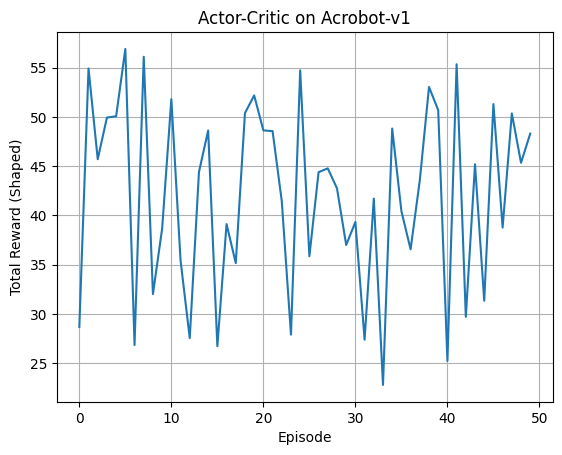

In [7]:
# Plot results
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Shaped)")
plt.title("Actor-Critic on Acrobot-v1")
plt.grid(True)
plt.show()

Thanks for uploading `RL5 Actor-Critic.ipynb`. This notebook implements the **vanilla Actor-Critic algorithm**, which combines policy-based (actor) and value-based (critic) methods.

Let’s go through it **line by line**, explaining **what it does, why it’s needed, and how it works**.

---

## 📦 Import Libraries

```python
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
```

* `gym`: Simulation environment (e.g., CartPole).
* `torch.nn`: For neural networks.
* `Categorical`: For sampling actions from probabilities.
* `optim`: Optimizer like Adam.
* `matplotlib`: For reward visualization.

---

## 🧠 Define Actor-Critic Model

```python
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc = nn.Linear(state_dim, 128)
        self.policy_head = nn.Linear(128, action_dim)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        return policy_logits, value
```

* Shared layer: 128 neurons with ReLU.
* `policy_head`: Outputs logits → probabilities for actions.
* `value_head`: Outputs predicted value of the state.
* This is the **Actor-Critic architecture**:

  * **Actor** decides actions.
  * **Critic** estimates how good the state is.

---

## 🏗️ Set Up Environment & Hyperparameters

```python
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
gamma = 0.99
```

* Initialize Gym environment and get dimensions.
* Set up the model and optimizer.
* `gamma`: Discount factor for future rewards.

---

## 🔁 Training Loop

```python
all_rewards = []

for episode in range(300):
    state = env.reset()[0]
    episode_reward = 0
```

Start a new episode and reset environment.

---

### 🧠 Interact with Environment

```python
for t in range(500):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    logits, value = model(state_tensor)
    dist = Categorical(logits=logits)
    action = dist.sample()
```

* Convert state to tensor.
* Get policy and value outputs.
* Sample action from the softmax distribution (stochastic policy).

```python
next_state, reward, done, truncated, _ = env.step(action.item())
```

* Take the action in the environment.

---

### 🧮 Compute Advantage and Loss

```python
next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
_, next_value = model(next_state_tensor)
```

Estimate value of the next state.

```python
td_target = reward + gamma * next_value * (1 - int(done or truncated))
advantage = td_target - value
```

* `td_target`: Target return using Temporal Difference.
* `advantage`: How much better this action was than expected.

```python
actor_loss = -dist.log_prob(action) * advantage.detach()
critic_loss = advantage.pow(2)
```

* **Actor loss**: maximize log-probability weighted by advantage.
* **Critic loss**: squared error between predicted and target value.

```python
loss = actor_loss + critic_loss
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

* Backpropagate combined loss and update the network.

```python
state = next_state
episode_reward += reward
if done or truncated:
    break
```

Update state and track total reward.

---

### 📉 Logging

```python
all_rewards.append(episode_reward)
if (episode + 1) % 10 == 0:
    print(f"Episode {episode+1}, Reward: {episode_reward}")
```

Print reward every 10 episodes.

---

## 📊 Plot Results

```python
plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Vanilla Actor-Critic on CartPole')
plt.grid()
plt.show()
```

Shows how rewards improve over episodes.

---

## ✅ Summary of Key Concepts

| Concept           | Description                                                      |
| ----------------- | ---------------------------------------------------------------- |
| Actor-Critic      | Combines policy (actor) and value estimation (critic).           |
| Stochastic Policy | Uses `Categorical` to sample actions from learned probabilities. |
| Advantage         | TD-target - predicted value: measures how good an action is.     |
| Loss              | Actor uses policy gradient loss; Critic uses MSE.                |
| Update            | Both actor and critic updated every step.                        |

---

Would you like a **diagram showing how Actor-Critic differs from PPO or DQN**?
